In [2]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Download necessary NLTK datasets
nltk.download('stopwords')

def load_imdb_data(base_dir):
    """
    Loads the IMDB dataset from the provided directory structure.
    Args:
        base_dir (str): Path to the 'aclImdb' directory.
    Returns:
        pd.DataFrame: DataFrame with 'text' and 'label' columns.
    """
    data = []
    for split in ['train', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        for sentiment in ['pos', 'neg']:
            sentiment_dir = os.path.join(split_dir, sentiment)
            label = 1 if sentiment == 'pos' else 0
            
            if not os.path.exists(sentiment_dir):
                print(f"Warning: Directory not found: {sentiment_dir}")
                continue
                
            print(f"Loading {split} - {sentiment}...")
         
            for filename in os.listdir(sentiment_dir):
                if filename.endswith(".txt"):
                    file_path = os.path.join(sentiment_dir, filename)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        review = f.read()
                        data.append({
                            'text': review,
                            'label': label,
                            'split': split  
                        })
    
    return pd.DataFrame(data)

def preprocess_text(text):
    """
    Implements the cleaning pipeline from Paper 3 & Paper 4:
    1. HTML removal (common in web-scraped IMDb data).
    2. Lowercasing.
    3. Regex cleaning (keeping letters only, removing special chars).
    4. Stopword removal (removing noise).
    5. Stemming (SnowballStemmer - aggressive reduction).
    """
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    
    cleaned_words = [stemmer.stem(w) for w in words if w not in stop_words]
    
    return ' '.join(cleaned_words)


dataset_path = r'C:\Users\sathw\Downloads\CapStone Project\aclImdb' 

if os.path.exists(dataset_path):
    print("Starting data load...")
    df = load_imdb_data(dataset_path)
    print(f"Data loaded. Total reviews: {len(df)}")
    
    print("Starting preprocessing (HTML removal, Stemming, etc.)...")
    df['clean_text'] = df['text'].apply(preprocess_text)
    
    print("Preprocessing complete!")
    print(df[['text', 'clean_text', 'label']].head())
    
    df.to_csv('imdb_processed.csv', index=False)
    print("Saved processed data to 'imdb_processed.csv'")
else:
    print(f"Error: Could not find dataset at '{dataset_path}'. Please unzip the folder first.")

Starting data load...
Loading train - pos...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sathw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading train - neg...
Loading test - pos...
Loading test - neg...
Data loaded. Total reviews: 50000
Starting preprocessing (HTML removal, Stemming, etc.)...
Preprocessing complete!
                                                text  \
0  Bromwell High is a cartoon comedy. It ran at t...   
1  Homelessness (or Houselessness as George Carli...   
2  Brilliant over-acting by Lesley Ann Warren. Be...   
3  This is easily the most underrated film inn th...   
4  This is not the typical Mel Brooks film. It wa...   

                                          clean_text  label  
0  bromwel high cartoon comedi ran time program s...      1  
1  homeless houseless georg carlin state issu yea...      1  
2  brilliant overact lesley ann warren best drama...      1  
3  easili underr film inn brook cannon sure flaw ...      1  
4  typic mel brook film much less slapstick movi ...      1  
Saved processed data to 'imdb_processed.csv'


In [3]:
def preprocess_text(text):
    """
    Updated cleaning pipeline (Maas et al. compliant):
    1. HTML removal.
    2. Lowercasing.
    3. Treat '!' as a feature: Add spaces around it so it becomes a token.
    4. Regex cleaning: Keep letters AND '!', remove other chars.
    5. Stopword removal.
    6. Stemming.
    """
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = re.sub(r'(!)', r' \1 ', text)

    # Remove punctuation/numbers BUT KEEP '!'
    text = re.sub(r'[^a-z\s!]', '', text)
    

    words = text.split()
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    
    cleaned_words = [stemmer.stem(w) for w in words if w not in stop_words or w == '!']
    
    return ' '.join(cleaned_words)

print("Re-starting preprocessing with exclamation marks preserved...")
df['clean_text'] = df['text'].apply(preprocess_text)

print("Preprocessing complete!")
print(df[['text', 'clean_text']].iloc[0])

df.to_csv('imdb_processed_v2.csv', index=False)
print("Saved improved data to 'imdb_processed_v2.csv'")

Re-starting preprocessing with exclamation marks preserved...
Preprocessing complete!
text          Bromwell High is a cartoon comedy. It ran at t...
clean_text    bromwel high cartoon comedi ran time program s...
Name: 0, dtype: object
Saved improved data to 'imdb_processed_v2.csv'


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"Training Samples: {len(train_df)}")
print(f"Testing Samples: {len(test_df)}")


tfidf = TfidfVectorizer(max_features=5000, token_pattern=r'\S+')
print("Vectorizing training data...")
X_train = tfidf.fit_transform(train_df['clean_text'])

print("Vectorizing testing data...")
X_test = tfidf.transform(test_df['clean_text'])

print("Feature Extraction Complete!")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

if '!' in tfidf.get_feature_names_out():
    print("Success: Exclamation mark '!' is included as a feature.")
else:
    print("Warning: '!' was not found in the features.")

Training Samples: 25000
Testing Samples: 25000
Vectorizing training data...
Vectorizing testing data...
Feature Extraction Complete!
Shape of X_train: (25000, 5000)
Shape of X_test: (25000, 5000)
Success: Exclamation mark '!' is included as a feature.


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Create a small subset for Grid Search (Hyperparameter Tuning)
# Training on 25,000 samples for every parameter combination takes too long.
# We find the best params on 2,000 samples, then apply them to the full 25,000.
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=2000, random_state=42, stratify=y_train
)

def evaluate_model(model, X_test, y_test, model_name):
    """
    Standard evaluation function to print metrics and plot confusion matrix.
    """
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    print(f"--- {model_name} Results ---")
    print(f"Prediction Time: {end_time - start_time:.2f} seconds")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return accuracy_score(y_test, y_pred)


Linear Kernel SVM
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Linear Params found: {'C': 1}
Training Linear model on full dataset (this may take 2-5 mins)...
--- Linear SVM Results ---
Prediction Time: 316.52 seconds
Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87     12500
    Positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



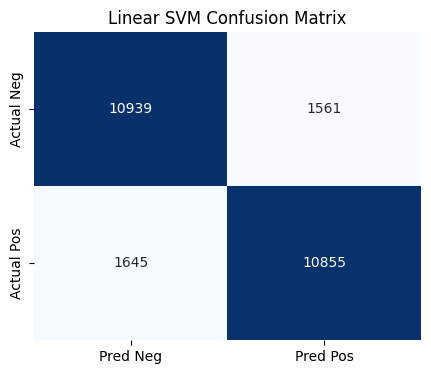

In [6]:
print("Linear Kernel SVM")

# 1. Define Parameters to Test
# Linear usually works well with C=1, but we check 0.1, 1, and 10 to be sure.
param_grid_linear = {'C': [0.1, 1, 10]}

grid_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=3, verbose=1, n_jobs=-1)
grid_linear.fit(X_train_sub, y_train_sub)

print(f"Best Linear Params found: {grid_linear.best_params_}")

best_linear_model = SVC(kernel='linear', C=grid_linear.best_params_['C'])
print("Training Linear model on full dataset (this may take 2-5 mins)...")
best_linear_model.fit(X_train, y_train)

linear_acc = evaluate_model(best_linear_model, X_test, y_test, "Linear SVM")

RBF Kernel SVM
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best RBF Params found: {'C': 10, 'gamma': 'scale'}
Training RBF model on full dataset (this usually takes longer than Linear)...
--- RBF SVM Results ---
Prediction Time: 540.42 seconds
Accuracy: 0.8734

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87     12500
    Positive       0.88      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



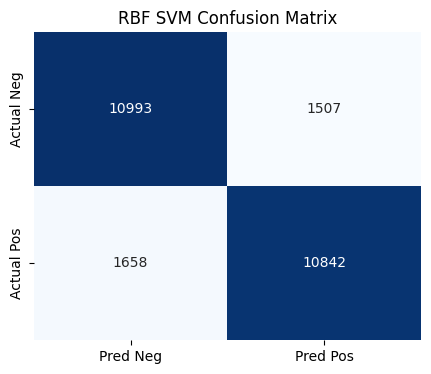

In [7]:
print("RBF Kernel SVM")

# 1. Define Parameters to Test
# RBF needs careful tuning. 
# Low Gamma = broad influence (smoother). High Gamma = isolated influence (complex).
param_grid_rbf = {
    'C': [1, 10], 
    'gamma': ['scale', 0.1, 1]
}
grid_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=3, verbose=1, n_jobs=-1)
grid_rbf.fit(X_train_sub, y_train_sub)

print(f"Best RBF Params found: {grid_rbf.best_params_}")
best_rbf_model = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
print("Training RBF model on full dataset (this usually takes longer than Linear)...")
best_rbf_model.fit(X_train, y_train)

rbf_acc = evaluate_model(best_rbf_model, X_test, y_test, "RBF SVM")

--- Starting Polynomial Kernel SVM ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Poly Params found: {'C': 1, 'coef0': 1, 'degree': 3}
Training Polynomial model on full dataset (This is the slowest model)...
--- Polynomial SVM Results ---
Prediction Time: 482.14 seconds
Accuracy: 0.8693

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87     12500
    Positive       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



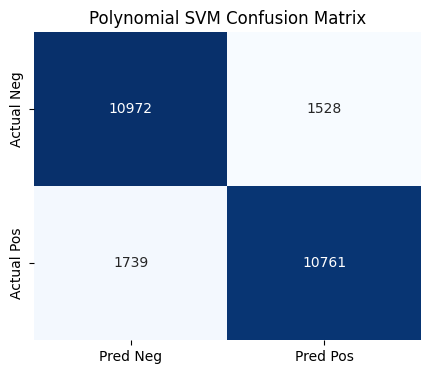

In [8]:
print("--- Starting Polynomial Kernel SVM ---")

# 1. Define Parameters to Test
# We stick to lower degrees (2 and 3) to prevent the model from exploding computationally.
param_grid_poly = {
    'degree': [2, 3],
    'C': [1, 10],
    'coef0': [0, 1] # 'coef0' is important for Poly kernel to allow interaction terms
}

grid_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=3, verbose=1, n_jobs=-1)
grid_poly.fit(X_train_sub, y_train_sub)

print(f"Best Poly Params found: {grid_poly.best_params_}")

best_poly_model = SVC(kernel='poly', 
                      degree=grid_poly.best_params_['degree'],
                      C=grid_poly.best_params_['C'],
                      coef0=grid_poly.best_params_['coef0'])

print("Training Polynomial model on full dataset (This is the slowest model)...")
best_poly_model.fit(X_train, y_train)

poly_acc = evaluate_model(best_poly_model, X_test, y_test, "Polynomial SVM")

Calculating final metrics for comparison...

--- Final Model Comparison ---
                Accuracy  Precision   Recall  F1-Score
Model                                                 
Linear SVM       0.87176   0.874275  0.86840  0.871328
RBF SVM          0.87340   0.877966  0.86736  0.872631
Polynomial SVM   0.86932   0.875661  0.86088  0.868208


<Figure size 1000x600 with 0 Axes>

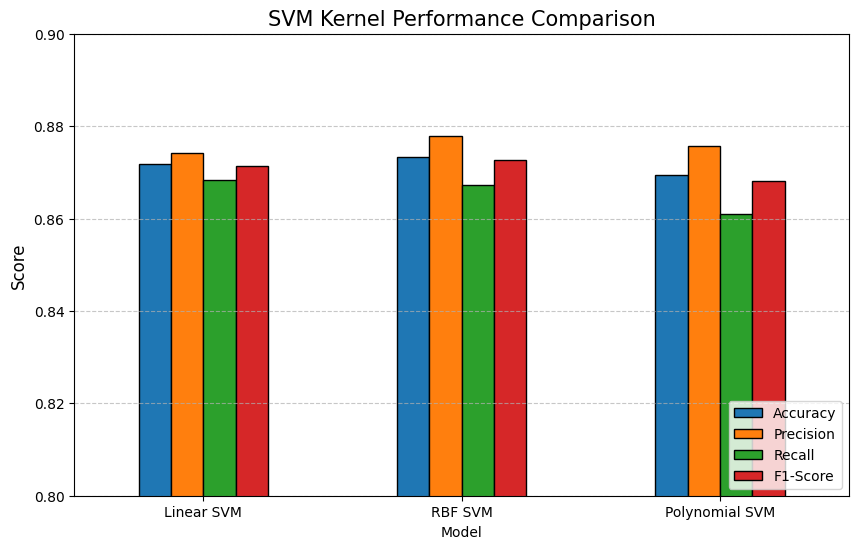

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 1. Define a helper to extract metrics from your trained models
def get_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

print("Calculating final metrics for comparison...")

metrics_list = []
metrics_list.append(get_metrics(best_linear_model, X_test, y_test, 'Linear SVM'))
metrics_list.append(get_metrics(best_rbf_model, X_test, y_test, 'RBF SVM'))
metrics_list.append(get_metrics(best_poly_model, X_test, y_test, 'Polynomial SVM'))

results_df = pd.DataFrame(metrics_list)
results_df.set_index('Model', inplace=True)

print("\n--- Final Model Comparison ---")
print(results_df)

plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(10, 6), ylim=(0.80, 0.90), edgecolor='black')
plt.title('SVM Kernel Performance Comparison', fontsize=15)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
import joblib

print("Saving the best model (RBF) and vectorizer to disk...")
joblib.dump(best_rbf_model, 'svm_rbf_sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Saving the best model (RBF) and vectorizer to disk...


['tfidf_vectorizer.pkl']